In [1]:
import cv2
import numpy as np
from scipy import misc
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
OPENPOSE_ROOT = '/home/albert/openpose/'

img_file = OPENPOSE_ROOT + 'examples/media/albert/woman.jpg'
pose_file = OPENPOSE_ROOT + 'examples/media/albert/pose/woman_keypoints.json'
render_file = OPENPOSE_ROOT + 'examples/media/albert/render/woman_rendered.png'

In [50]:
# https://github.com/Panchamy/RegionGrowing
def region_growing(img, seed, region_threshold=0.5, iterations=-1):
    #Parameters for region growing
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    region_size = 0
    intensity_difference = 0
    neighbor_points_list = []
    neighbor_intensity_list = []

    #Mean of the segmented region
    init_region_mean = float(img[seed])
    region_mean = float(img[seed])
    region = []

    #Input image parameters
    height, width = img.shape
    image_size = height * width

    #Initialize segmented output image
    segmented_img = np.zeros((height, width), np.uint8)

    it = 0

    # Region growing until intensity difference becomes greater than certain threshold
    # or the loop has run a certain number of iterations
    while True:
        segmented_img[seed[0], seed[1]] = 255
        region.append(img[seed[0], seed[1]])
        region_mean = (region_mean*region_size + img[seed[0], seed[1]])/(region_size+1)

        # print(img[seed[0], seed[1]], region_mean, region_size)
        region_size += 1

        #Loop through neighbor pixels
        for i in range(4):
            #Compute the neighbor pixel position
            x_new = seed[0] + neighbors[i][0]
            y_new = seed[1] + neighbors[i][1]

            #Boundary Condition - check if the coordinates are inside the image
            check_inside = (x_new >= 0) & (y_new >= 0) & (x_new < height) & (y_new < width)

            #Add neighbor if inside and not already in segmented_img
            if check_inside:
                if segmented_img[x_new, y_new] == 0:
                    neighbor_points_list.append([x_new, y_new])
                    neighbor_intensity_list.append(img[x_new, y_new])
                    region.append(img[x_new, y_new])
                    segmented_img[x_new, y_new] = 255

                    region_mean = (region_mean*region_size + img[x_new, y_new])/(region_size+1)
                    # print(img[x_new, y_new], region_mean, region_size)
                    region_size += 1

        #Add pixel with intensity nearest to the mean to the region
        distance = abs(neighbor_intensity_list-region_mean)
        pixel_distance = min(distance)
        index = np.where(distance == pixel_distance)[0][0]

        #Update the seed value
        seed = neighbor_points_list[index]
        # print(seed)
        #Remove the value from the neighborhood lists
        neighbor_intensity_list[index] = neighbor_intensity_list[-1]
        neighbor_points_list[index] = neighbor_points_list[-1]

        it += 1
        # print(it)

        if iterations > -1:
            if it >= iterations:
                break
        else:
            if ((abs(region_mean - init_region_mean) > region_threshold) or 
                (region_size >= image_size)):
                break

    return segmented_img

In [59]:
img = misc.imread(img_file) # cv2.imread() outputs different data for some reason?
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
segmented_img = region_growing(gray, (186, 195), region_threshold=15)

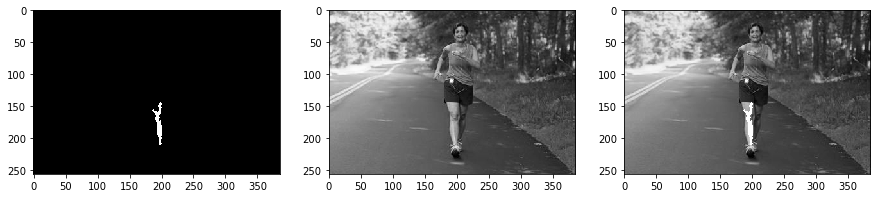

In [60]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(segmented_img, cmap=plt.cm.gray)
plt.subplot(132)
plt.imshow(gray, cmap=plt.cm.gray)
plt.subplot(133)
plt.imshow(np.maximum(segmented_img, gray), cmap=plt.cm.gray)
plt.show()